In [ ]:
# Import necessary libraries
import numpy as np
import os
from glob import glob
from skimage.io import imread
from skimage import transform
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from google.colab import files
from zipfile import ZipFile

In [ ]:
# # Step 1: Upload Training and Validation Data
# # -------------------------------------------

# # Upload the training dataset
# uploaded = files.upload()
# with ZipFile('train_sample_edge2shoes.zip', 'r') as zip_ref:
#     zip_ref.extractall('./edges2shoes/')  # This is your training dataset folder

# # Upload the validation dataset
# uploaded = files.upload()
# with ZipFile('val_edge2shoes.zip', 'r') as zip_ref:
#     zip_ref.extractall('./val_edge2shoes/')  # This is your validation dataset folder



In [ ]:
# Print files to verify extraction
print("Training files: ", os.listdir('./edges2shoes/'))
print("Validation files: ", os.listdir('./val_edge2shoes/'))

FileNotFoundError: [Errno 2] No such file or directory: './edges2shoes/'

In [ ]:
# Step 2: Load the training and validation datasets
# Set the paths to the train and validation folders
train_dataset_path = '/content/edges2shoes'  # Path to training dataset
val_dataset_path = '/content/val_edge2shoes'      # Path to validation dataset

# Load a specific number of images (or the whole dataset) for both train and val
batch_size_train = 128  # Specify the number of training images you want to load
batch_size_val = 32     # Specify the number of validation images you want to load

# Load training data
train_imgs_A, train_imgs_B = load_data(train_dataset_path, batch_size=batch_size_train, is_val=False)
print(f'Training images loaded: {len(train_imgs_A)} pairs')

# Load validation data
val_imgs_A, val_imgs_B = load_data(val_dataset_path, batch_size=batch_size_val, is_val=True)
print(f'Validation images loaded: {len(val_imgs_A)} pairs')

Loaded 128 images with shapes: (128, 128, 128, 3), (128, 128, 128, 3)
Training images loaded: 128 pairs
Loaded 32 images with shapes: (32, 128, 128, 3), (32, 128, 128, 3)
Validation images loaded: 32 pairs


In [ ]:
def load_data(dataset_path, batch_size=1, is_val=False):
    image_paths = glob(os.path.join(dataset_path, '*.jpg'))

    if len(image_paths) == 0:
        print(f"No images found in the path: '{dataset_path}'")
        return [], []

    batch_images = np.random.choice(image_paths, size=batch_size)
    img_res = (128, 128)
    imgs_A = []
    imgs_B = []

    for img_path in batch_images:
        img = imread(img_path)
        h, w, _ = img.shape
        _w = int(w / 2)

        img_A, img_B = img[:, _w:, :], img[:, :_w, :]

        img_A = transform.resize(img_A, img_res)
        img_B = transform.resize(img_B, img_res)

        if not is_val and np.random.random() < 0.5:
            img_A = np.fliplr(img_A)
            img_B = np.fliplr(img_B)

        imgs_A.append(img_A)
        imgs_B.append(img_B)

    imgs_A = np.array(imgs_A)
    imgs_B = np.array(imgs_B)

    if imgs_A.shape[1:] != (128, 128, 3):
        raise ValueError(f"Unexpected shape of images: {imgs_A.shape[1:]}")

    imgs_A = imgs_A / 127.5 - 1.
    imgs_B = imgs_B / 127.5 - 1.

    print(f"Loaded {len(imgs_A)} images with shapes: {imgs_A.shape}, {imgs_B.shape}")
    return imgs_A, imgs_B


In [ ]:
# Test the load_data function
imgs_A, imgs_B = load_data(train_dataset_path, batch_size=8)
print(f"imgs_A: {imgs_A.shape}, imgs_B: {imgs_B.shape}")

# Ensure the data shapes are correct
if len(imgs_A) != 8 or len(imgs_B) != 8:
    print("Error: Unexpected number of images loaded.")


Loaded 8 images with shapes: (8, 128, 128, 3), (8, 128, 128, 3)
imgs_A: (8, 128, 128, 3), imgs_B: (8, 128, 128, 3)


In [ ]:


# Step 3: Define the Generator and Discriminator Models
# -----------------------------------------------------

def build_generator():
    def conv2d(layer_input, filters, f_size=4, bn=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(negative_slope=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    d0 = Input(shape=img_shape)

    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8)
    u3 = deconv2d(u2, d4, gf*8)
    u4 = deconv2d(u3, d3, gf*4)
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(d0, output_img)

def build_discriminator():
    def d_layer(layer_input, filters, f_size=4, bn=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(negative_slope=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img_A = Input(shape=img_shape)
    img_B = Input(shape=img_shape)
    combined_imgs = Concatenate(axis=-1)([img_A, img_B])

    d1 = d_layer(combined_imgs, df, bn=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(d4)

    return Model([img_A, img_B], validity)


In [ ]:
# Step 5: Compile Models
# ----------------------
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

gf = 64  # Generator filter size
df = 64  # Discriminator filter size

def compile_models():
    # Reinitialize the optimizer
    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    # Build the generator
    generator = build_generator()

    # Define inputs
    img_A = Input(shape=img_shape)
    img_B = Input(shape=img_shape)

    # Generate fake images
    fake_A = generator(img_B)

    # Discriminator's decision
    discriminator.trainable = False
    valid = discriminator([fake_A, img_B])

    # Combined model (for training the generator)
    combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
    combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer)

    return generator, discriminator, combined

In [ ]:
# Calculate disc_patch after building the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])


In [ ]:
# Define the disc_patch based on the discriminator's output shape
discriminator_output = discriminator.output_shape
print("Discriminator output shape:", discriminator_output)
disc_patch = discriminator.output_shape[1:]
print("Discriminator patch shape:", disc_patch)

Discriminator output shape: (None, 8, 8, 1)
Discriminator patch shape: (8, 8, 1)


In [ ]:
# generator=build_generator()
# generator.summary()

In [ ]:
# # Print the discriminator's architecture and output shape
# discriminator.summary()


In [ ]:
def validate(val_dataset_path, generator, epoch, examples=5, dim=(2, 5), figsize=(15, 6)):
    imgs_A, imgs_B = load_data(val_dataset_path, batch_size=examples, is_val=True)
    fake_A = generator.predict(imgs_B)

    # Concatenate images for display
    gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A], axis=0)
    gen_imgs = (gen_imgs + 1) / 2  # Rescale to [0, 1]

    titles = ['Input', 'Generated', 'Ground Truth']
    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    cnt = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            if cnt < len(gen_imgs):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[cnt % 3])
                axs[i, j].axis('off')
                cnt += 1
            else:
                axs[i, j].axis('off')
    plt.tight_layout()
    plt.savefig(f'validation_images_epoch_{epoch}.png')
    plt.show()


In [ ]:
def train_models(train_dataset_path, epochs, batch_size, sample_interval=1):
    # Compile models
    generator, discriminator, combined = compile_models()

    for epoch in range(epochs):
        for batch_data in load_data(train_dataset_path, batch_size):
            if isinstance(batch_data, tuple) and len(batch_data) == 2:
                imgs_A, imgs_B = batch_data
            else:
                print(f"Unexpected batch_data format: {batch_data}")
                continue

            # Ensure data shape is correct
            assert imgs_A.shape[1:] == (128, 128, 3), f"Unexpected shape for imgs_A: {imgs_A.shape}"
            assert imgs_B.shape[1:] == (128, 128, 3), f"Unexpected shape for imgs_B: {imgs_B.shape}"

            # Create labels for the discriminator
            valid = np.ones((batch_size,) + disc_patch)
            fake = np.zeros((batch_size,) + disc_patch)

            # Generate fake images
            fake_A = generator.predict(imgs_B)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
            d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator
            g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

            # Print progress
            print(f"Epoch {epoch}/{epochs} - [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss[0]:.4f}]")

            # Validation
            if epoch % sample_interval == 0:
                validate(val_dataset_path, generator, epoch)
                fake_A = generator.predict(imgs_B)
                for i in range(len(fake_A)):
                  plt.imsave(f'generated_image_epoch_{epoch}_batch_{i}.png', (fake_A[i]+1)/2)

    print("Training complete.")


In [ ]:
# Ensure correct data paths
train_dataset_path = "edges2shoes"
val_dataset_path = "val_edge2shoes"

# Compile models
generator, discriminator, combined = compile_models()

# Train the model with validation and visualize every epoch
train_models(train_dataset_path, epochs=10, batch_size=32, sample_interval=1)


Streaming output truncated to the last 5000 lines.
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]]

  ...

  [[-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   ...
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]]

  [[-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   ...
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]]

  [[-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   ...
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]]]


 [[[-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99

Loaded 5 images with shapes: (5, 128, 128, 3), (5, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


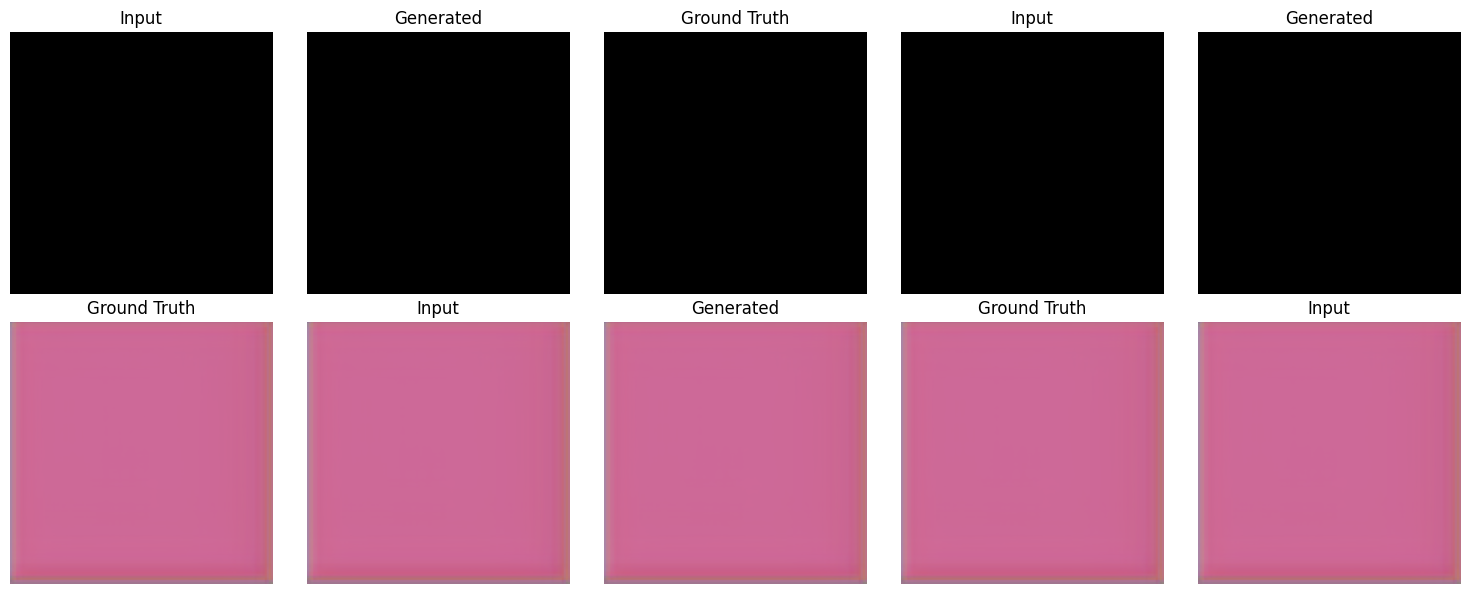

In [ ]:
# Ensure the generator and validation dataset path are correctly set
generator, _, _ = compile_models()  # Get the trained generator
val_dataset_path = "val_edge2shoes"  # Path to validation dataset

# Validate the results and visualize
validate(val_dataset_path, generator, epoch=10)  # Replace 10 with the last epoch number if needed


In [ ]:
from tensorflow.keras.utils import plot_model

def create_cgan_architecture_diagram():
    # Ensure models are built
    generator, discriminator, combined = compile_models()

    # Save and plot the combined model
    plot_model(combined, to_file='cgan_combined_model.png', show_shapes=True, show_layer_names=True)

    print("cGAN combined model diagram saved as 'cgan_combined_model.png'.")

create_cgan_architecture_diagram()


cGAN combined model diagram saved as 'cgan_combined_model.png'.


None
